In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.model_selection
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.tree
import sklearn.dummy
import sklearn.datasets
import matplotlib.colors
import sklearn.metrics
import logging
import itertools

%matplotlib inline

import mlutil
importlib.reload(mlutil)
mlu = mlutil.MLUtil()
mlu.set_jupyter_defaults()

In [2]:
def get_digits_binary_data(mc=False):
    dataset = sklearn.datasets.load_digits()
    X, y = dataset.data, dataset.target
    if mc:
        return sklearn.model_selection.train_test_split(X, y, random_state=0)
    
    # create digits with 2 classes: negative class 0: not 1,  positive class 1: 1
    y_binary_imbalanced = y.copy()
    y_binary_imbalanced[y_binary_imbalanced != 1] = 0
    return sklearn.model_selection.train_test_split(X, y_binary_imbalanced, random_state=0)

def model_report(title, clf, *args):
    '''
    Display report of a classification model for clf
    if len(args) == 2: X_test, y_test
    if len(args) == 4: X_train, X_test, y_train, y_test
    '''
    assert isinstance(clf, sklearn.base.BaseEstimator), "2nd arg must be classifier"
    
    X_train, X_test, y_train, y_test = [None] * 4
    if len(args) == 2:
        X_test, y_test = args
    elif len(args) == 4:
        X_train, X_test, y_train, y_test = args

    title = "{} - {}".format(type(clf).__name__, title)
    params = ['kernel', 'gamma', 'C', 'strategy']
    d = clf.get_params()
    print("{}: {}".format(title, ",".join("{}={}".format(p, d[p]) for p in params if p in d)))
    if X_train is not None:
        print('Train Accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
        
    if X_test is not None:

        y_predict = clf.predict(X_test)
        cf = sklearn.metrics.confusion_matrix(y_test, y_predict)
        cols = ['Pred:Neg', 'Pred:Pos']
        labels = ['Class:Neg', 'Class:Pos']
        str_cf = [[f"{cf[0][0]}(TN)", f"{cf[0][1]}(FP)"], [f"{cf[1][0]}(FN)", f"{cf[1][1]}(TP)"]]
        df_confusion = pd.DataFrame(str_cf, columns=cols, index=labels)
        print('Confusion martix:\n{}'.format(df_confusion))
        print()
        metrics = (
            ('Test Accuracy (TP+TN)/(ALL)', sklearn.metrics.accuracy_score(y_test, y_predict)),
            ('Precision TP/(TP+FP)', sklearn.metrics.precision_score(y_test, y_predict)),
            ('Recall TP/(TP+FN)', sklearn.metrics.recall_score(y_test, y_predict)),
            ('F1 (2*Prec*Recall)/(Prec+Recall)', sklearn.metrics.f1_score(y_test, y_predict))
            )
        w = max(len(t[0]) for t in metrics) + 1
        for n, v in metrics:
            print('{:{w}}: {:.2f}'.format(n, v, w=w))
        print()
        print(sklearn.metrics.classification_report(y_test, y_predict, target_names=['not 1', '1']))


In [3]:
X_train, X_test, y_train, y_test = get_digits_binary_data()

# accuracy of SVC with RBF
clf = sklearn.svm.SVC(kernel='rbf', random_state=0).fit(X_train, y_train)
model_report('Binary Digits', clf, X_train, X_test, y_train, y_test)    

SVC - Binary Digits: kernel=rbf,gamma=auto,C=1.0
Train Accuracy: 1.00
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  407(TN)    0(FP)
Class:Pos   41(FN)    2(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.91
Precision TP/(TP+FP)             : 1.00
Recall TP/(TP+FN)                : 0.05
F1 (2*Prec*Recall)/(Prec+Recall) : 0.09

             precision    recall  f1-score   support

      not 1       0.91      1.00      0.95       407
          1       1.00      0.05      0.09        43

avg / total       0.92      0.91      0.87       450



In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = get_digits_binary_data()
params = {'C': 1e9, 'gamma': 1e-07}
clf = SVC(**params).fit(X_train, y_train)
y_scores = clf.decision_function(X_test)
y_predict = y_scores > 100
confusion_matrix(y_test, y_predict)

array([[407,   0],
       [ 43,   0]])

array([[402,   5],
       [  7,  36]])

In [31]:
TP = 96
TN = 19
FN = 4
FP = 8
ALL = (TP+TN +FP+FN)
print('Accuracy: {:.3f}'.format((TP+TN)/ALL))
print('Precision: {:.3f}'.format((TP)/(TP+FP)))
print('Recall: {:.3f}'.format((TP)/(TP+FN)))

#TP+FN = 1 (COND POS)
#FP+TN = 99 (COND NEG)
CP = 10
CN = 990
TP = 10
TN = 900
FN = (CP - TP)
FP = (CN - TN)
ALL= (TN+FN+TP+FP)
print('Accuracy: {:.3f} ALL = {} TP={}, TN={}, FN={}, TN={}'.format((TP+TN)/ALL, ALL, TP, TN, FN, TN))

print(1-1/100)

Accuracy: 0.906
Precision: 0.923
Recall: 0.960
Accuracy: 0.910 ALL = 1000 TP=10, TN=900, FN=0, TN=900
0.99



### Dummy classifiers

In [4]:
# Majority - Always predict negative class
dummy_majority = sklearn.dummy.DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
model_report('Majority', dummy_majority, X_train, X_test, y_train, y_test)
y_dummy_predictions = dummy_majority.predict(X_test)
#y_dummy_predictions

DummyClassifier - Majority: strategy=most_frequent
Train Accuracy: 0.90
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  407(TN)    0(FP)
Class:Pos   43(FN)    0(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.90
Precision TP/(TP+FP)             : 0.00
Recall TP/(TP+FN)                : 0.00
F1 (2*Prec*Recall)/(Prec+Recall) : 0.00

             precision    recall  f1-score   support

      not 1       0.90      1.00      0.95       407
          1       0.00      0.00      0.00        43

avg / total       0.82      0.90      0.86       450



c:\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [5]:
# Linear SVM is better than RBF
lsvm = sklearn.svm.SVC(kernel='linear', random_state=0).fit(X_train, y_train)
model_report('Linear/Binary ', lsvm, X_train, X_test, y_train, y_test)

SVC - Linear/Binary : kernel=linear,gamma=auto,C=1.0
Train Accuracy: 1.00
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  402(TN)    5(FP)
Class:Pos    5(FN)   38(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.98
Precision TP/(TP+FP)             : 0.88
Recall TP/(TP+FN)                : 0.88
F1 (2*Prec*Recall)/(Prec+Recall) : 0.88

             precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.88      0.88      0.88        43

avg / total       0.98      0.98      0.98       450



### Confusion matrices
#### Binary (two-class)

In [6]:
# dummy random predicitons with same class proportion to training set
clf = sklearn.dummy.DummyClassifier(strategy='stratified').fit(X_train, y_train)
model_report('Random class-proportional dummy', clf, X_train, X_test, y_train, y_test)

DummyClassifier - Random class-proportional dummy: strategy=stratified
Train Accuracy: 0.81
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  363(TN)   44(FP)
Class:Pos   40(FN)    3(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.81
Precision TP/(TP+FP)             : 0.06
Recall TP/(TP+FN)                : 0.07
F1 (2*Prec*Recall)/(Prec+Recall) : 0.07

             precision    recall  f1-score   support

      not 1       0.90      0.89      0.90       407
          1       0.06      0.07      0.07        43

avg / total       0.82      0.81      0.82       450



In [7]:
# Logistic regression 
clf = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
model_report('', clf, X_train, X_test, y_train, y_test)

LogisticRegression - : C=1.0
Train Accuracy: 0.99
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  401(TN)    6(FP)
Class:Pos    6(FN)   37(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.97
Precision TP/(TP+FP)             : 0.86
Recall TP/(TP+FN)                : 0.86
F1 (2*Prec*Recall)/(Prec+Recall) : 0.86

             precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.86      0.86      0.86        43

avg / total       0.97      0.97      0.97       450



In [8]:
# Decision Tree
clf = sklearn.tree.DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
model_report('', clf, X_train, X_test, y_train, y_test)


DecisionTreeClassifier - : 
Train Accuracy: 0.94
Confusion martix:
          Pred:Neg Pred:Pos
Class:Neg  400(TN)    7(FP)
Class:Pos   17(FN)   26(TP)

Test Accuracy (TP+TN)/(ALL)      : 0.95
Precision TP/(TP+FP)             : 0.79
Recall TP/(TP+FN)                : 0.60
F1 (2*Prec*Recall)/(Prec+Recall) : 0.68

             precision    recall  f1-score   support

      not 1       0.96      0.98      0.97       407
          1       0.79      0.60      0.68        43

avg / total       0.94      0.95      0.94       450



### Evaluation metrics for binary classificaction

In [9]:
# decision function & predicted_probability
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
y_scores = lr.decision_function(X_test)
y_proba = lr.predict_proba(X_test)
df = pd.DataFrame({'Target': y_test, 'Score': y_scores, 'Proba': y_proba[:,1]}, columns=['Target', 'Score', 'Proba'])
df['Tresh'] = (df.Score > 0).astype(int)
df.head(20)

,Target,Score,Proba,Tresh
0,0,-23.176547,8.601087e-11,0
1,0,-13.541224,1.315590e-06,0
2,0,-21.722500,3.681611e-10,0
3,0,-18.907578,6.145299e-09,0
4,0,-19.736035,2.683793e-09,0
5,0,-9.749346,5.832940e-05,0
6,1,5.234900,9.947009e-01,1
7,0,-19.307161,4.121036e-09,0
8,0,-25.101016,1.255358e-11,0
9,0,-21.827251,3.315472e-10,0


In [10]:
# Evaluation metrics for multiple classifiers
clf_list = [
    ('Random class-proportional(dummy)', sklearn.dummy.DummyClassifier(strategy='stratified')),
    ('SVM', sklearn.svm.SVC()),
    ('Logistic Regression', sklearn.linear_model.LogisticRegression()),
    ('Decision Tree', sklearn.tree.DecisionTreeClassifier(max_depth=2)),
]
for name, clf in clf_list:
    print(name)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_predicted, target_names=['not 1', '1']))

Random class-proportional(dummy)
             precision    recall  f1-score   support

      not 1       0.90      0.88      0.89       407
          1       0.08      0.09      0.09        43

avg / total       0.82      0.81      0.82       450

SVM
             precision    recall  f1-score   support

      not 1       0.91      1.00      0.95       407
          1       1.00      0.05      0.09        43

avg / total       0.92      0.91      0.87       450

Logistic Regression
             precision    recall  f1-score   support

      not 1       0.99      0.99      0.99       407
          1       0.86      0.86      0.86        43

avg / total       0.97      0.97      0.97       450

Decision Tree
             precision    recall  f1-score   support

      not 1       0.96      0.98      0.97       407
          1       0.79      0.60      0.68        43

avg / total       0.94      0.95      0.94       450



In [11]:
# predicted probability
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
lr.predict_proba(X_test)


array([[  1.00e+00,   8.60e-11],
       [  1.00e+00,   1.32e-06],
       [  1.00e+00,   3.68e-10],
       [  1.00e+00,   6.15e-09],
       [  1.00e+00,   2.68e-09],
       [  1.00e+00,   5.83e-05],
       [  5.30e-03,   9.95e-01],
       [  1.00e+00,   4.12e-09],
       [  1.00e+00,   1.26e-11],
       [  1.00e+00,   3.32e-10],
       [  1.00e+00,   3.25e-11],
       [  1.00e+00,   3.15e-09],
       [  1.00e+00,   1.57e-10],
       [  1.00e+00,   1.99e-05],
       [  1.00e+00,   6.71e-06],
       [  1.00e+00,   1.70e-05],
       [  1.36e-05,   1.00e+00],
       [  1.00e+00,   9.85e-13],
       [  1.00e+00,   2.60e-06],
       [  1.00e+00,   5.94e-12],
       [  1.00e+00,   3.96e-10],
       [  1.00e+00,   4.99e-06],
       [  1.00e+00,   4.33e-11],
       [  1.00e+00,   8.93e-05],
       [  1.00e+00,   3.71e-14],
       [  1.00e+00,   3.04e-08],
       [  1.00e+00,   4.61e-08],
       [  1.00e+00,   1.22e-16],
       [  1.00e+00,   2.32e-14],
       [  1.00e+00,   1.33e-12],
       [  

### Precision-recall curves

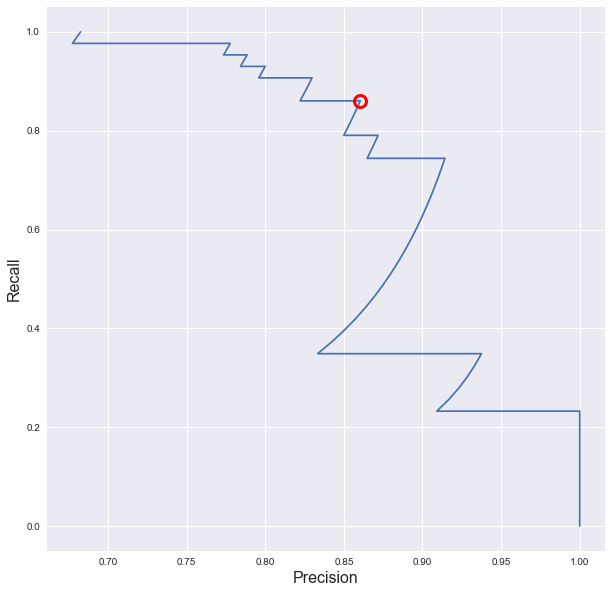

In [22]:
X_train, X_test, y_train, y_test = get_digits_binary_data()
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
y_scores_lr = lr.decision_function(X_test)

precision, recall, threshold = sklearn.metrics.precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(threshold))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure(figsize=(10,10))
plt.plot(precision, recall, label='Precision Recall curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize=12, fillstyle='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
#plt.axes().set_aspect('equal')

In [25]:
recall

array([ 0.  ,  0.02,  0.05,  0.07,  0.09,  0.12,  0.14,  0.16,  0.19,
        0.21,  0.23,  0.23,  0.26,  0.28,  0.3 ,  0.33,  0.35,  0.35,
        0.35,  0.37,  0.4 ,  0.42,  0.44,  0.47,  0.49,  0.51,  0.53,
        0.56,  0.58,  0.6 ,  0.63,  0.65,  0.67,  0.7 ,  0.72,  0.74,
        0.74,  0.74,  0.77,  0.79,  0.79,  0.81,  0.84,  0.86,  0.86,
        0.86,  0.88,  0.91,  0.91,  0.91,  0.93,  0.93,  0.95,  0.95,
        0.98,  0.98,  0.98,  0.98,  0.98,  0.98,  0.98,  0.98,  0.98,  1.  ])

### Receiver-Operating-Characterstic (ROC) curves, Area-Under-Curve (AUC)

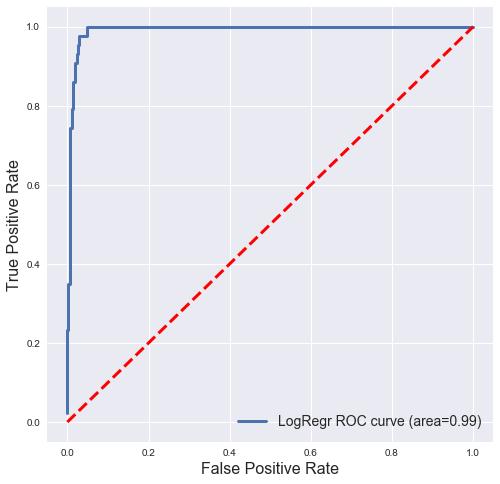

In [16]:
X_train, X_test, y_train, y_test = get_digits_binary_data()
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
y_scores_lr = lr.decision_function(X_test)
fpr_lr, tpr_lr, _ = sklearn.metrics.roc_curve(y_test, y_scores_lr)
roc_auc_lr = sklearn.metrics.auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,8))
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area={:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.plot([0,1], [0,1], color='red', lw=3, linestyle='--')
plt.legend(fontsize=14)


gamma = 0.01 accuracy  = 0.91 AUC = 1.00
gamma = 0.10 accuracy  = 0.90 AUC = 0.98
gamma = 0.20 accuracy  = 0.90 AUC = 0.66
gamma = 1.00 accuracy  = 0.90 AUC = 0.50


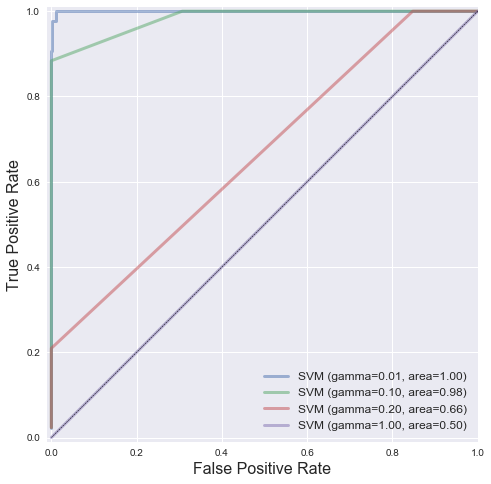

In [19]:
X_train, X_test, y_train, y_test = get_digits_binary_data()
lr = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
y_scores_lr = lr.decision_function(X_test)
fpr_lr, tpr_lr, _ = sklearn.metrics.roc_curve(y_test, y_scores_lr)
roc_auc_lr = sklearn.metrics.auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [.01, .1, .2, 1.0]:
    svm = sklearn.svm.SVC(gamma=g).fit(X_train, y_train)
    y_score_svm = svm.decision_function(X_test)
    fpr_svm, tpr_svm, _ = sklearn.metrics.roc_curve(y_test, y_score_svm)
    roc_auc_svm = sklearn.metrics.auc(fpr_svm, tpr_svm)
    accuracy_svm = svm.score(X_test, y_test)
    print('gamma = {:.2f} accuracy  = {:.2f} AUC = {:.2f}'.format(g, accuracy_svm, roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=.5, label='SVM (gamma={:.2f}, area={:0.2f})'.format(g, roc_auc_svm))
    
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.plot([0,1], [0,1], color='k', lw=.5, linestyle='--')
plt.legend(fontsize=12)
plt.axes().set_aspect('equal')

### Evaluation measures for multi-class classification

#### Multiclass confusion matrix

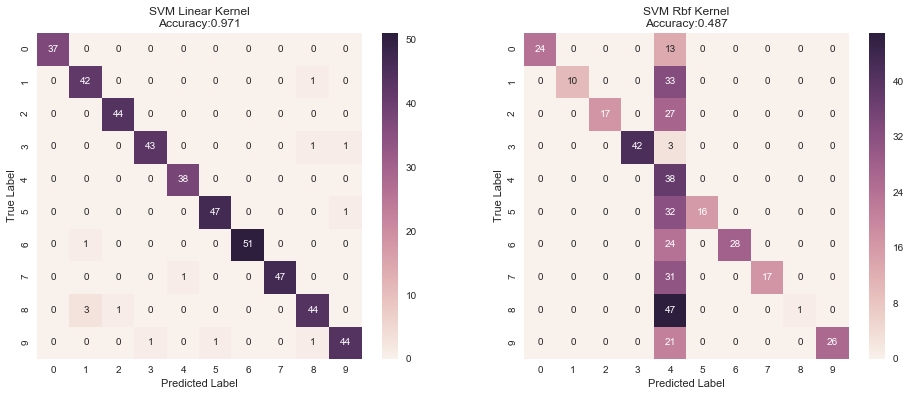

In [36]:
X_train, X_test, y_train, y_test = get_digits_binary_data(mc=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for ax, kernel in zip(axs, ['linear', 'rbf']):
    svm = sklearn.svm.SVC(kernel=kernel).fit(X_train, y_train)
    y_predicted = svm.predict(X_test)
    confusion_mc = sklearn.metrics.confusion_matrix(y_test, y_predicted)
    df_cm = pd.DataFrame(confusion_mc, index=range(10), columns=range(10))
    sns.heatmap(df_cm, annot=True, ax=ax)
    ax.set_title('SVM {} Kernel\nAccuracy:{:.3f}'.format(kernel.capitalize(), sklearn.metrics.accuracy_score(y_test, y_predicted)))
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    


#### Multiclass classification report, Micro/Macro averaged metrics

In [39]:
X_train, X_test, y_train, y_test = get_digits_binary_data(mc=True)
svm = sklearn.svm.SVC(kernel=kernel).fit(X_train, y_train)
y_predicted = svm.predict(X_test)
print('SVM rbf Report: \n{}'.format(sklearn.metrics.classification_report(y_test, y_predicted)))

print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(sklearn.metrics.precision_score(y_test,y_predicted, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(sklearn.metrics.precision_score(y_test,y_predicted, average = 'macro')))

print('Micro-averaged f1 = {:.2f} (treat instances equally)'
      .format(sklearn.metrics.f1_score(y_test,y_predicted, average = 'micro')))
print('Macro-averaged f1 = {:.2f} (treat classes equally)'
      .format(sklearn.metrics.f1_score(y_test,y_predicted, average = 'macro')))


SVM rbf Report: 
             precision    recall  f1-score   support

          0       1.00      0.65      0.79        37
          1       1.00      0.23      0.38        43
          2       1.00      0.39      0.56        44
          3       1.00      0.93      0.97        45
          4       0.14      1.00      0.25        38
          5       1.00      0.33      0.50        48
          6       1.00      0.54      0.70        52
          7       1.00      0.35      0.52        48
          8       1.00      0.02      0.04        48
          9       1.00      0.55      0.71        47

avg / total       0.93      0.49      0.54       450

Micro-averaged precision = 0.49 (treat instances equally)
Macro-averaged precision = 0.91 (treat classes equally)
Micro-averaged f1 = 0.49 (treat instances equally)
Macro-averaged f1 = 0.54 (treat classes equally)


### Regression evaluation metrics

Linear model, coefficients:  [-698.8]  intercep:  151.801124067
Mean squared error(Linear): 4646.74
Mean squared error(Dummy):  4965.13
r2_score (Linear):          0.06
r2_score (Dummy):           -0.00


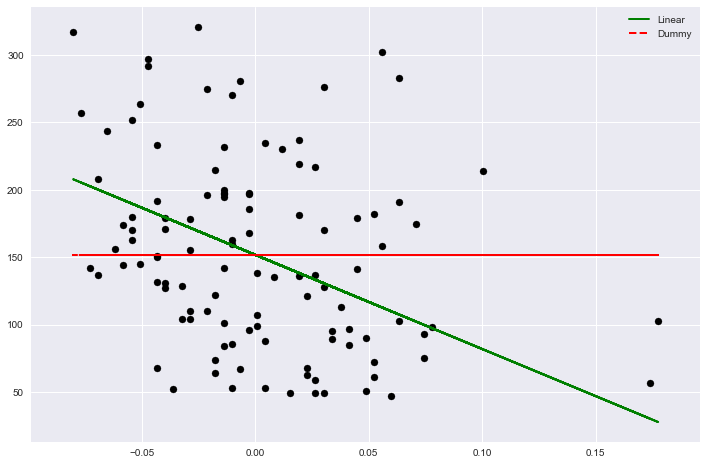

In [73]:
db = sklearn.datasets.load_diabetes()
X = db.data[:, np.newaxis, 6]
y = db.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

lm = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
lm_dummy_mean = sklearn.dummy.DummyRegressor(strategy='mean').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy = lm_dummy_mean.predict(X_test)

print('Linear model, coefficients: ', lm.coef_, ' intercep: ', lm.intercept_)
print('Mean squared error(Linear): {:.2f}'.format(sklearn.metrics.mean_squared_error(y_test, y_predict)))
print('Mean squared error(Dummy):  {:.2f}'.format(sklearn.metrics.mean_squared_error(y_test, y_predict_dummy)))
print('r2_score (Linear):          {:.2f}'.format(sklearn.metrics.r2_score(y_test, y_predict)))
print('r2_score (Dummy):           {:.2f}'.format(sklearn.metrics.r2_score(y_test, y_predict_dummy)))

plt.figure(figsize=(12,8))
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_predict, color='green', linewidth=2, label='Linear')
plt.plot(X_test, y_predict_dummy, color='red', linewidth=2, linestyle='dashed', label='Dummy')
plt.legend()

### Model selection using evaluation metrics

#### Cross-validation example

In [82]:
X_train, X_test, y_train, y_test  = get_digits_binary_data()
X, y = np.r_[X_train, X_test], np.r_[y_train, y_test]
clf = sklearn.svm.SVC(kernel='linear', C=1)

print('Cross-vaidation (accuracy)', sklearn.model_selection.cross_val_score(clf, X, y, cv=5))
print('Cross-vaidation (AUC)', sklearn.model_selection.cross_val_score(clf, X, y, cv=5, scoring='roc_auc'))
print('Cross-vaidation (recall)', sklearn.model_selection.cross_val_score(clf, X, y, cv=5, scoring='recall'))

Cross-vaidation (accuracy) [ 0.96  0.99  0.98  0.96  0.96]
Cross-vaidation (AUC) [ 0.99  1.    1.    0.99  0.99]
Cross-vaidation (recall) [ 0.89  0.92  0.94  0.92  0.78]


#### Grid search example

In [84]:
X_train, X_test, y_train, y_test  = get_digits_binary_data()
X, y = np.r_[X_train, X_test], np.r_[y_train, y_test]
clf = sklearn.svm.SVC(kernel='rbf')
grid_values = {'gamma': [.001, .01, .05, 0.1, 1, 10, 100]}

# default metrics to optimize over grid params: accuracy
grid_clf_acc = sklearn.model_selection.GridSearchCV(clf, param_grid=grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test)
print('Grid best parameter (max. accurarcy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid params: AUC
grid_clf_auc = sklearn.model_selection.GridSearchCV(clf, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test)
print('Testset AUC: ', sklearn.metrics.roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)


Grid best parameter (max. accurarcy):  {'gamma': 0.001}
Grid best score (accuracy):  0.996288047513
Testset AUC:  0.999828581224
Grid best parameter (max. AUC):  {'gamma': 0.001}
Grid best score (AUC):  0.99987412783


#### Evaluation metrics supported for selection

In [85]:
print(sorted(list(sklearn.metrics.scorer.SCORERS.keys())))

['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']


### Two-feature classification example using the digits dataset

#### Optimizing a classifier using different evaluation metrics

Grid best parameter (maxprecision): {'class_weight': {1: 2}}
Grid best score (maxprecision): 0.538535522906923
Grid best parameter (maxrecall): {'class_weight': {1: 50}}
Grid best score (maxrecall): 0.9211685679692496
Grid best parameter (maxf1): {'class_weight': {1: 4}}
Grid best score (maxf1): 0.512865326216708
Grid best parameter (maxroc_auc): {'class_weight': {1: 20}}
Grid best score (maxroc_auc): 0.8899405591603957


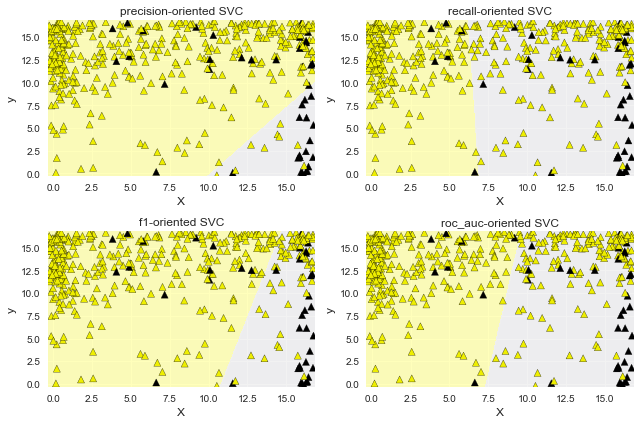

In [100]:
X_train, X_test, y_train, y_test  = get_digits_binary_data()

# Create a two-feature input vector, jitter the points (add small amount of random noise) incase there are areas in
# feature space where many instances have same feature
jitter_delta = .25
X_twovar_train = X_train[:, [20,59]] + np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test = X_test[:, [20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = sklearn.svm.SVC(kernel='linear').fit(X_twovar_train, y_train)
grid_values = {'class_weight': ['balanced', {1:2}, {1:3}, {1:4}, {1:5}, {1:10}, {1:20}, {1:50}]}
plt.figure(figsize=(9,6))
for i, eval_metric in enumerate(['precision', 'recall', 'f1', 'roc_auc']):
    grid_clf_custom = sklearn.model_selection.GridSearchCV(clf, param_grid=grid_values, scoring=eval_metric)
    grid_clf_custom.fit(X_twovar_train, y_train)
    print('Grid best parameter (max{}): {}'.format(eval_metric, grid_clf_custom.best_params_))
    print('Grid best score (max{}): {}'.format(eval_metric, grid_clf_custom.best_score_))
    plt.subplots_adjust(wspace=.3, hspace=.3)
    ax = plt.subplot(2, 2, i+1)
    mlu.plot_class_regions_for_classifier_subplot(grid_clf_custom, None, ax, None, X_twovar_test, None, y_test, ['X', 'y'])
    plt.title(eval_metric + '-oriented SVC')
plt.tight_layout()


#### Precision-recall curve for the default SVC classifier (with balanced class weights)

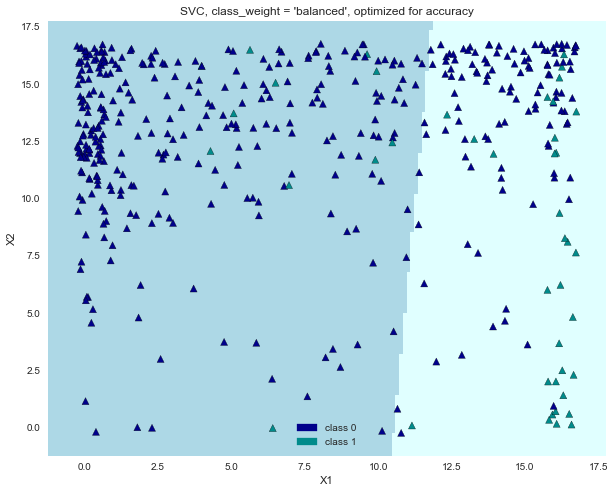

In [106]:
importlib.reload(mlutil)
mlu = mlutil.MLUtil()

X_train, X_test, y_train, y_test  = get_digits_binary_data()


# create a two-feature input vector matching the example plot above
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]]+ np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = sklearn.svm.SVC(kernel='linear', class_weight='balanced').fit(X_twovar_train, y_train)

y_scores = clf.decision_function(X_twovar_test)

fig, ax = plt.subplots(figsize=(10,8))

mlu.plot_2class_clf(clf, None, ax, None, X_twovar_test, None, y_test)
ax.set_title("SVC, class_weight = 'balanced', optimized for accuracy")




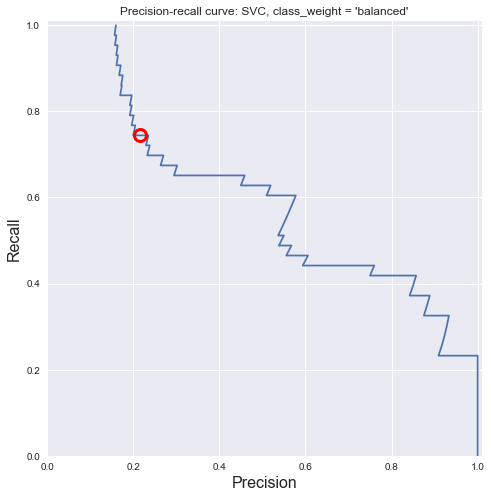

At zero threshold, precision: 0.22, recall: 0.74


In [108]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]


plt.figure(figsize=(10,8))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title ("Precision-recall curve: SVC, class_weight = 'balanced'")
plt.plot(precision, recall, label = 'Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize=12, fillstyle='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()
print('At zero threshold, precision: {:.2f}, recall: {:.2f}'
      .format(closest_zero_p, closest_zero_r))

In [30]:
a = np.random.randn(1000)
m = a.mean()
np.sum((a - m))

-2.1316282072803006e-14